<a href="https://colab.research.google.com/github/sanjogmish/Health-Insurance-Cross-Sell-Prediction/blob/main/Health_Insurance_Cross_Sell_Prediction_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Health Insurance Cross Sell Prediction: Modelling**

## **Importing Modules**

In [ ]:
from google.colab import drive
#@title Importing all libraries and dependencies
!pip install lime
!pip install catboost
!pip install shap
!pip install eli5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score,precision_score,log_loss,f1_score,roc_auc_score,classification_report,roc_curve,precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
import lime
from lime import lime_tabular
import shap
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb
import tensorflow as tf
from warnings import filterwarnings
import pickle
filterwarnings("ignore")
plt.style.use('ggplot')
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Reading Data**

In [ ]:
# We have already preprocessed data in another file, here we are reading the preprocessed data 

file_path = '/content/drive/MyDrive/Capstone 2 Classification/New Final Dataset/'
X_train = pd.read_csv(file_path+"X_train_df")
X_test = pd.read_csv(file_path+"X_test_df")
y_train = pd.read_csv(file_path+"y_train_series")
y_test = pd.read_csv(file_path+"y_test_series")

In [ ]:
# Dropping the unnecesssary columns that got read while creating the DataFrames
X_train = X_train.drop('Unnamed: 0',axis=1)
X_test = X_test.drop('Unnamed: 0',axis=1)
y_train = y_train.drop('Unnamed: 0',axis=1).values.reshape(-1,1)
y_test = y_test.drop('Unnamed: 0',axis=1).values.reshape(-1,1)

## **Some user defined functions that we are going to use throughtout the code**

In [ ]:
#@title **Function for plotting roc curve**
def roc_plot(true,pred):
    # Rounding off roc auc score upto 3 digits
    auc = round(roc_auc_score(true,pred),3)

    # Plotting an roc-auc curve
    fpr, tpr, thresholds = roc_curve(true,pred)

    # Plotting a precision recall curve
    prec,recall,thresh = precision_recall_curve(true,pred)
  
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
    ax1.plot([0, 1], [0, 1], linestyle='--')
    ax1.plot(fpr,tpr,marker='.',label=f'Area : {auc}')
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    ax1.set_title("ROC curve")
    ax1.legend(loc='best',fontsize=14)

    ax2.plot(prec,recall,marker='.')
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision recall curve")
    fig.suptitle('Testing curves',size=20)  


In [ ]:
#@title **Function for getting all metric scores**
def get_metric(classifier,p_c_a=False):

    if p_c_a:
      training_pred = classifier.predict(X_train_pca)
      testing_pred = classifier.predict(X_test_pca)
      roc_train = classifier.predict_proba(X_train_pca)[:,1] 
      roc_test = classifier.predict_proba(X_test_pca)[:,1]
    else:
      training_pred = classifier.predict(X_train)
      testing_pred = classifier.predict(X_test)
      roc_train = classifier.predict_proba(X_train)[:,1]
      roc_test = classifier.predict_proba(X_test)[:,1]

    print("The classification report for training is \n")
    print(classification_report(y_train,training_pred),"\n")
    
    print("The classification report for testing is \n")
    print(classification_report(y_test,testing_pred),"\n")
    
    labels = ['0', '1']
    cm = confusion_matrix(y_test, testing_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix for testing data')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    roc_plot(y_test,roc_test)
    
    
    print("The scores are summed up in the dataframe below")
    
    metrics = [accuracy_score,recall_score,precision_score,log_loss,f1_score]
    metric_name = ['Roc Auc','Accuracy','Recall','Precision','Log loss','F1 score']
    
    zipped_list = [(round(roc_auc_score(y_train,roc_train),3),round(roc_auc_score(y_test,roc_test),3))]
    for i in metrics:
        tr = round(i(y_train,training_pred),3)
        ts = round(i(y_test,testing_pred),3)
        zipped_list.append((tr,ts))
    metric_df = pd.DataFrame(zipped_list,index=metric_name,columns=['Train','Test'])    
    true_dict = pd.Series(y_test.flatten()).value_counts().to_dict()
    pred_dict = pd.Series(testing_pred).value_counts().to_dict()

    tmp_df = pd.DataFrame(zip(true_dict.values(),pred_dict.values()),columns = ['Actual','Predicted'],index=pred_dict.keys())
    tmp_df = tmp_df.div(tmp_df.sum(axis=0), axis=1)
    tmp_df.plot(kind='bar', rot=0, xlabel='Response',ylabel='Percentages', figsize=(14, 6))
    
    return metric_df   

In [ ]:
# Doing a K-fold Cross validation
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)

## **Baseline dummy model**

In [ ]:
# Creating this baseline model, to get the base scores. Later on we will try build on to improve the scores from this.
# It can be seen this model is predicting the biased class

dummy_clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred_dummy = dummy_clf.predict(X_test)

#Distribution of y test
print(f"Y actual: \n")
print(pd.Series(y_test.flatten()).value_counts(),"\n")

#Distribution of y predicted
print(f"Y predicted: \n")
print(pd.Series(y_pred_dummy).value_counts())

Y actual: 

0    66972
1     9250
dtype: int64 

Y predicted: 

0    76222
dtype: int64


## **Modelling With Logistic Regression**

In [ ]:
# Creating a logistic regression object and fitting on train data
lr_clf = LogisticRegression(fit_intercept=True, max_iter=10000)
lr_clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The classification report for training is 

              precision    recall  f1-score   support

           0       0.90      0.66      0.76    267427
           1       0.73      0.92      0.82    267427

    accuracy                           0.79    534854
   macro avg       0.81      0.79      0.79    534854
weighted avg       0.81      0.79      0.79    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     66972
           1       0.27      0.92      0.42      9250

    accuracy                           0.69     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.69      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.844,0.842
Accuracy,0.793,0.693
Recall,0.923,0.916
Precision,0.732,0.272
Log loss,7.166,10.613
F1 score,0.817,0.420


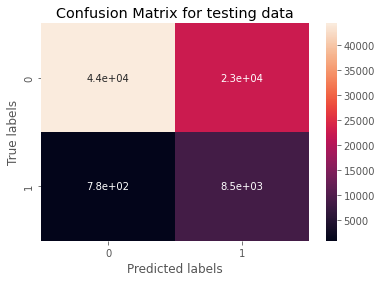

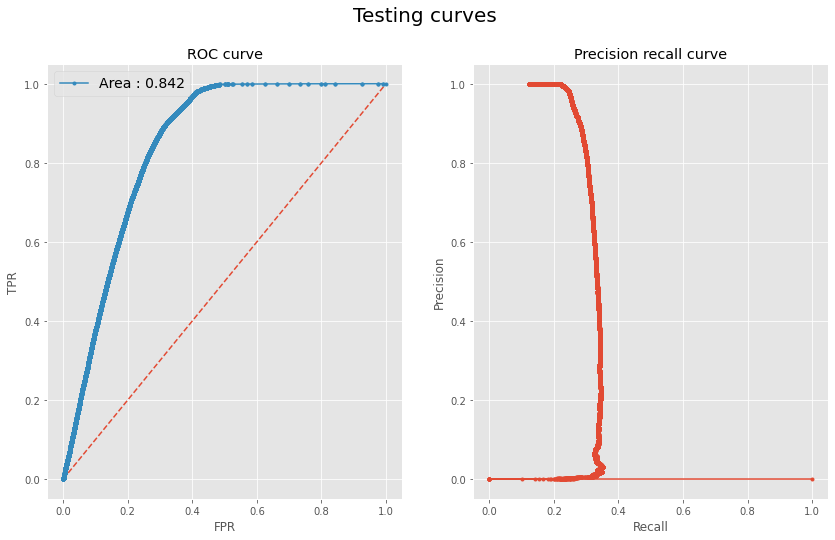

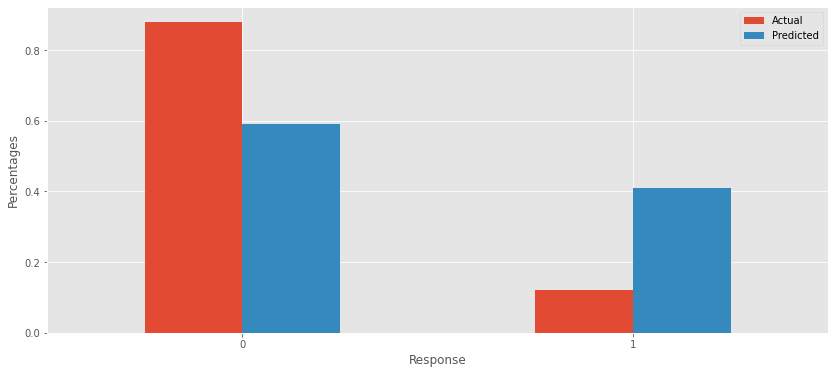

In [ ]:
# Getting all the scores for logistic regression
get_metric(lr_clf)

## **Cross Validation On Logistic Regression**

In [ ]:
# Setting parameter grid to find the optimal parameters for Logistic Regression
lr_param = {'penalty' : ['l1', 'l2', 'elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
           }

In [ ]:
# Doing a grid search to get the best parameters
lr_grid = GridSearchCV(estimator=LogisticRegression(),
                       param_grid = lr_param,refit=True,n_jobs=-1,
                       cv = cv, verbose=2, scoring='roc_auc')
lr_grid.fit(X_train,y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.7min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [ ]:
# Getting the model with best fitted hyperparameters
optimal_lr_clf = lr_grid.best_estimator_ 

The classification report for training is 

              precision    recall  f1-score   support

           0       0.90      0.66      0.76    267427
           1       0.73      0.92      0.82    267427

    accuracy                           0.79    534854
   macro avg       0.81      0.79      0.79    534854
weighted avg       0.81      0.79      0.79    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.66      0.79     66972
           1       0.27      0.92      0.42      9250

    accuracy                           0.69     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.69      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.844,0.842
Accuracy,0.793,0.693
Recall,0.923,0.916
Precision,0.732,0.272
Log loss,7.166,10.613
F1 score,0.817,0.420


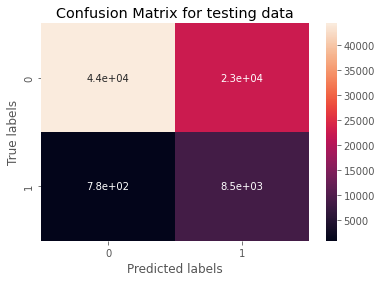

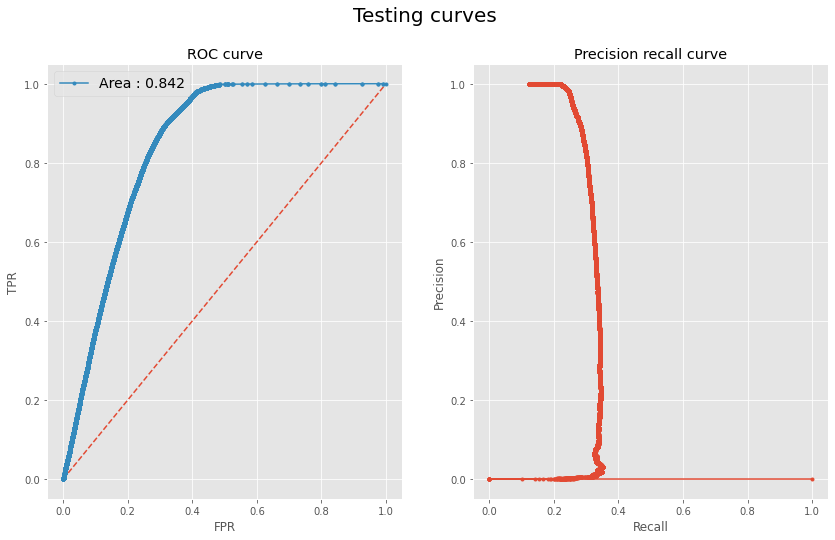

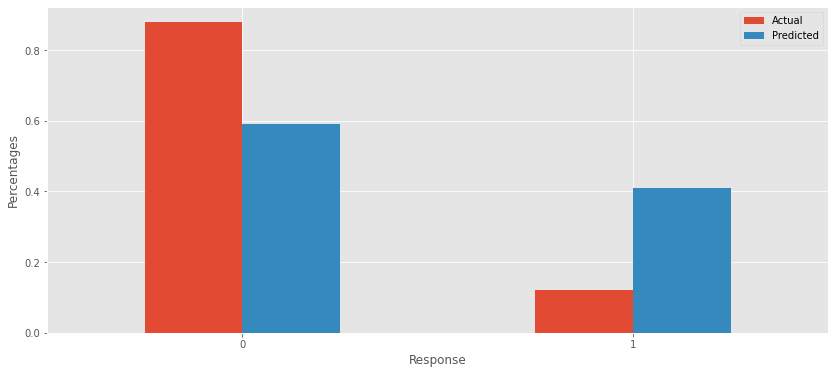

In [ ]:
# Checking scores on the optimal model
get_metric(optimal_lr_clf)

## **Modelling With Gaussian Naive Bayes**

In [ ]:
# Creating an object of Gaussian NB
nb_clf = GaussianNB()

In [ ]:
# Fitting the model object
nb_clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

The classification report for training is 

              precision    recall  f1-score   support

           0       0.87      0.69      0.77    267427
           1       0.74      0.90      0.81    267427

    accuracy                           0.79    534854
   macro avg       0.80      0.79      0.79    534854
weighted avg       0.80      0.79      0.79    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     66972
           1       0.28      0.89      0.43      9250

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.89      0.71      0.76     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.829,0.825
Accuracy,0.791,0.710
Recall,0.896,0.891
Precision,0.740,0.281
Log loss,7.228,10.009
F1 score,0.811,0.427


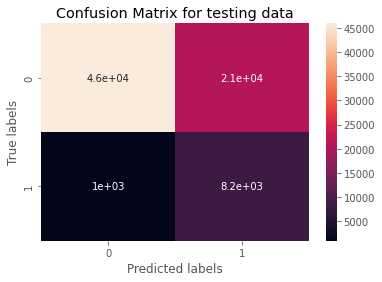

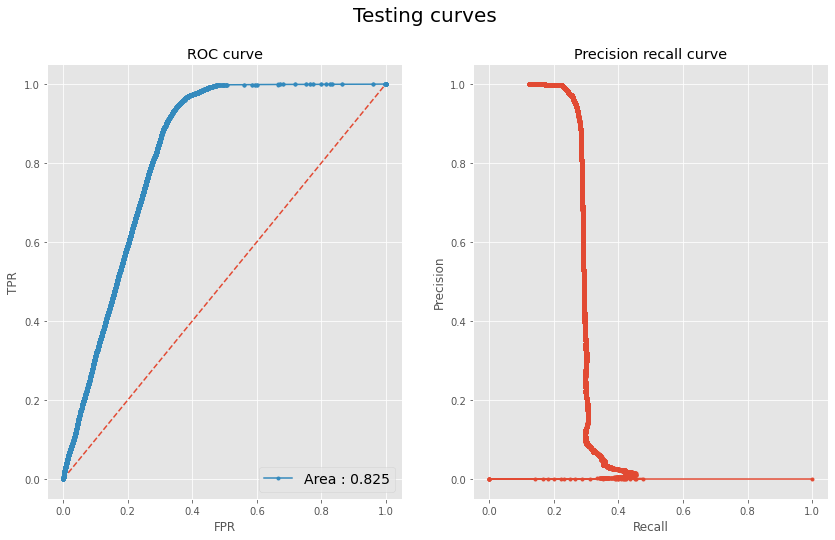

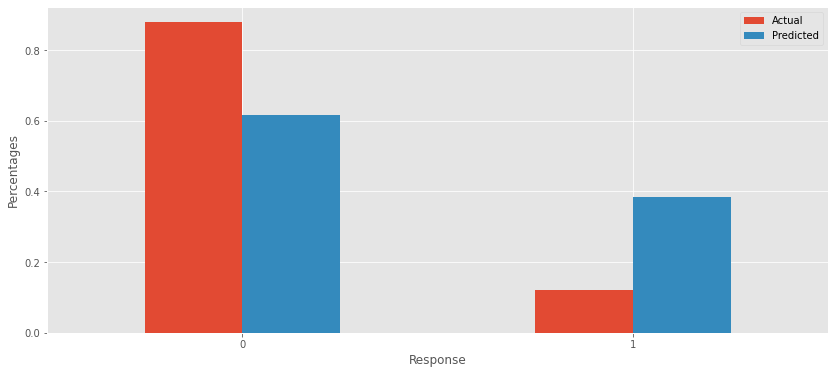

In [ ]:
# Checking scores of Gaussian NB
get_metric(nb_clf)

In [ ]:
# Doing a cross validation, we will find mean of scores on all folds
nb_scores = cross_validate(GaussianNB(),X_train, y_train, scoring = 'roc_auc', cv = 5, return_train_score=True,return_estimator=True,verbose = 2,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [ ]:
# Mean of training auc score
print(f"The auc score for training is {round(nb_scores['train_score'].mean(),2)}")

The auc score for training is 0.83


In [ ]:
# Mean of testing auc score
print(f"The auc score for testing is {round(nb_scores['test_score'].mean(),2)}")

The auc score for testing is 0.83


## **Modelling With Random Forest Classifier**

In [ ]:
# Fitting object of Random Forest
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

The classification report for training is 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267427
           1       1.00      1.00      1.00    267427

    accuracy                           1.00    534854
   macro avg       1.00      1.00      1.00    534854
weighted avg       1.00      1.00      1.00    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     66972
           1       0.33      0.29      0.31      9250

    accuracy                           0.84     76222
   macro avg       0.62      0.60      0.61     76222
weighted avg       0.83      0.84      0.84     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,1.000,0.831
Accuracy,1.000,0.844
Recall,1.000,0.288
Precision,1.000,0.333
Log loss,0.003,5.402
F1 score,1.000,0.309


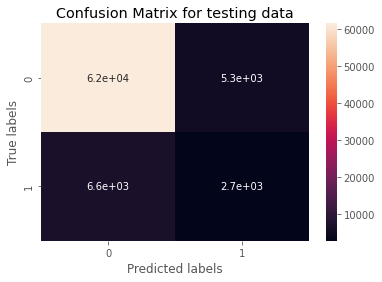

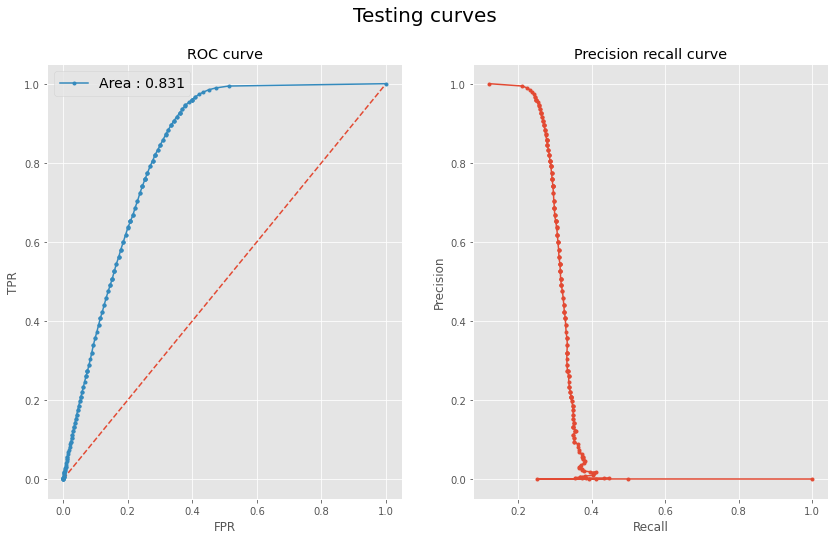

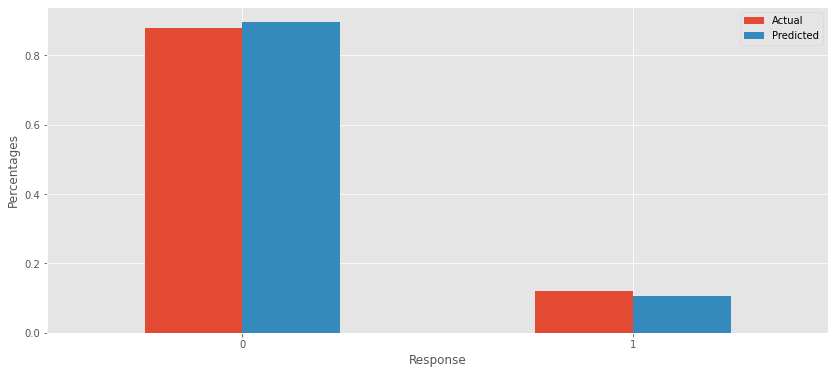

In [ ]:
# Checking scores of Random Forest
get_metric(rf_clf)

In [ ]:
# We are saving all the model objects as they taking long time for train and hyppertuning so that we do not have to fit them again. 
# Rather just load the pickled image 
pickle_path = '/content/drive/MyDrive/Capstone 2 Classification/Model ka achar/'

In [ ]:
# Pickle of Random Forest Model
rf_pkl = pickle.load( open(pickle_path+'rf_varun.pkl','rb')) 

In [ ]:
rf_pkl

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
# Model with tuned hyperparameters
optimal_rf = RandomForestClassifier(n_estimators=105,min_samples_leaf=2,max_depth=5,n_jobs=-1)
optimal_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

The classification report for training is 

              precision    recall  f1-score   support

           0       0.92      0.67      0.77    267427
           1       0.74      0.94      0.83    267427

    accuracy                           0.81    534854
   macro avg       0.83      0.81      0.80    534854
weighted avg       0.83      0.81      0.80    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66972
           1       0.28      0.92      0.43      9250

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.886,0.847
Accuracy,0.806,0.699
Recall,0.943,0.919
Precision,0.740,0.277
Log loss,6.713,10.396
F1 score,0.829,0.426


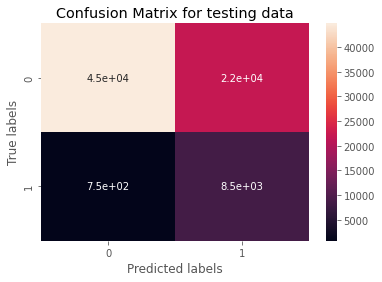

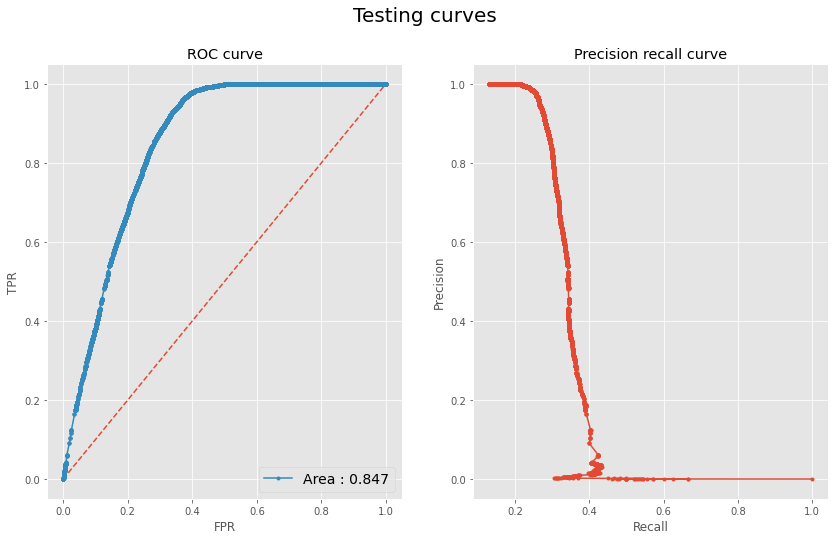

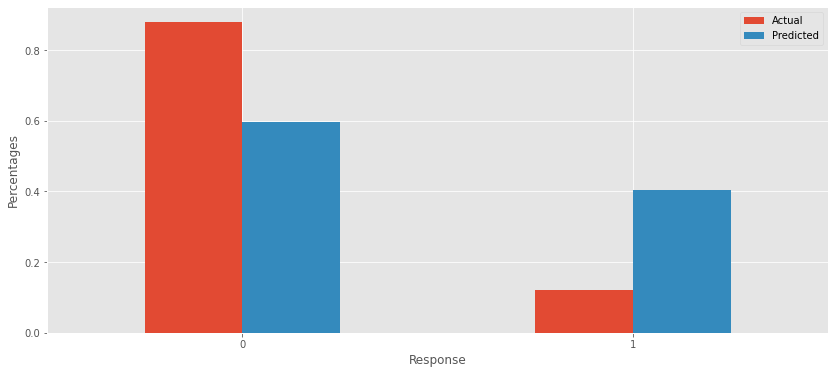

In [ ]:
# Checking scores of optimal Random Forest
get_metric(optimal_rf)

## **Modelling With AdaBoost**

In [ ]:
# Reading image of AdaBoost model
ada_boost = pickle.load(open(pickle_path+'ada.pkl','rb'))

The classification report for training is 

              precision    recall  f1-score   support

           0       0.92      0.71      0.80    267427
           1       0.76      0.93      0.84    267427

    accuracy                           0.82    534854
   macro avg       0.84      0.82      0.82    534854
weighted avg       0.84      0.82      0.82    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.97      0.70      0.82     66972
           1       0.29      0.86      0.43      9250

    accuracy                           0.72     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.72      0.77     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.911,0.838
Accuracy,0.820,0.724
Recall,0.935,0.858
Precision,0.760,0.287
Log loss,6.209,9.547
F1 score,0.839,0.430


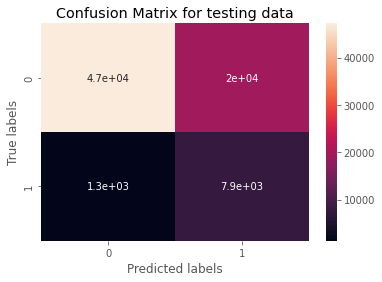

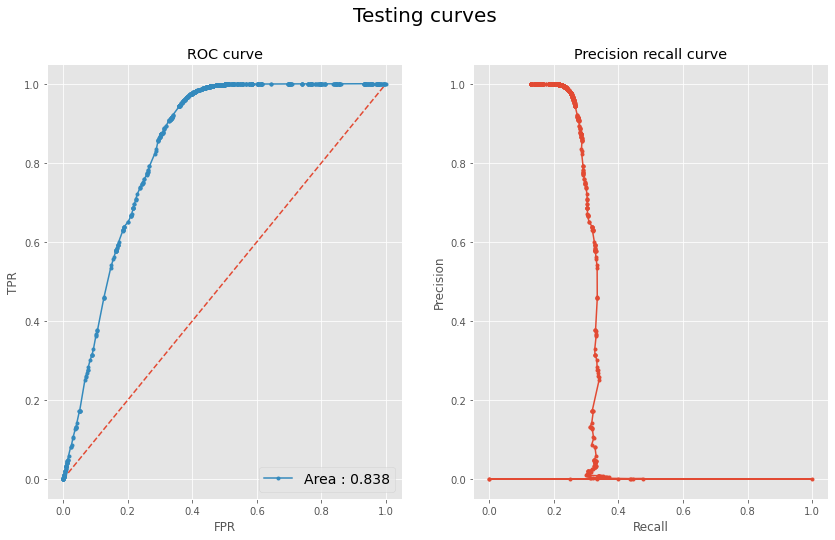

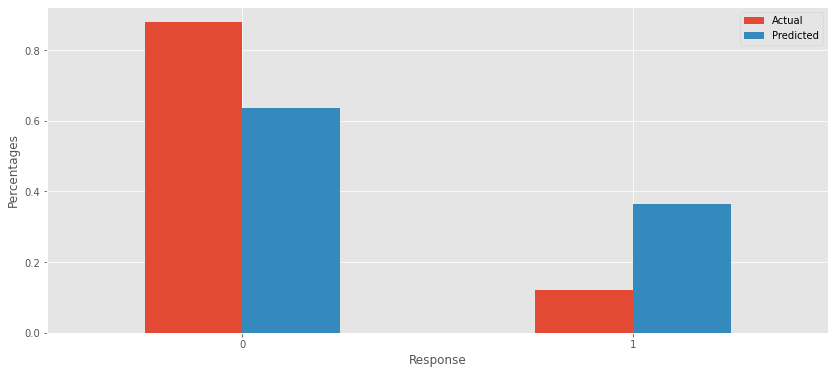

In [ ]:
# Checking scores of AdaBoost
get_metric(ada_boost)

# **Doing PCA, as we see there is some sort of overfitting. So next few models would be trained on PCA's data.**

In [ ]:
# Running the loop for the number of columns we have, and checking suum of variance explained by each components
for i in range(X_train.shape[1]):
    X_train_PCA = PCA(i).fit(X_train)
    print(i, sum(X_train_PCA.explained_variance_ratio_))

0 0
1 0.4470206101648612
2 0.6420585681880967
3 0.8215595462816018
4 0.8931359681449169
5 0.9322927900433979
6 0.9603234534154919
7 0.9824375041863752
8 0.9958757299446542
9 0.9976817274280293
10 0.9988610296012663
11 1.0000000000000002


In [ ]:
# 6 Components are explaining 96% variance in data which is pretty good. Not going to 7 as we want to decrease overfitting.
# Also, there is not much difference between 6th and 7th component
Pca = PCA(6)

# Fittinf train data and transforming the test data
X_train_pca = Pca.fit_transform(X_train)
X_test_pca = Pca.transform(X_test)

## **Modelling With LGBM Classifier**

In [ ]:
# Fitting LGBM model with hypertuned parameters
lgbm_clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=42,n_jobs=-1)

lgbm_clf.fit(X_train_pca, y_train,eval_metric='auc',eval_set=(X_test_pca , y_test),verbose=50)

# Finding roc auc score on train and test data
lgbm_pred_train = lgbm_clf.predict_proba(X_train_pca)[:,1]
lgbm_pred_test = lgbm_clf.predict_proba(X_test_pca)[:,1]

roc_train_lgbm = roc_auc_score(y_train, lgbm_pred_train)
roc_test_lgbm = roc_auc_score(y_test, lgbm_pred_test) 

[50]	valid_0's auc: 0.844104
[100]	valid_0's auc: 0.844932
[150]	valid_0's auc: 0.845166
[200]	valid_0's auc: 0.845079
[250]	valid_0's auc: 0.844901
[300]	valid_0's auc: 0.845228
[350]	valid_0's auc: 0.845444
[400]	valid_0's auc: 0.845435
[450]	valid_0's auc: 0.845462
[500]	valid_0's auc: 0.845392


In [ ]:
print(f"Lightgbm  train roc: {round(roc_train_lgbm,2)}")
print(f"Lightgbm  test roc: {round(roc_test_lgbm,2)}")

Lightgbm  train roc: 0.87
Lightgbm  test roc: 0.85


The classification report for training is 

              precision    recall  f1-score   support

           0       0.92      0.67      0.78    267427
           1       0.74      0.94      0.83    267427

    accuracy                           0.81    534854
   macro avg       0.83      0.81      0.80    534854
weighted avg       0.83      0.81      0.80    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.67      0.79     66972
           1       0.28      0.92      0.42      9250

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.869,0.845
Accuracy,0.806,0.697
Recall,0.944,0.920
Precision,0.740,0.276
Log loss,6.697,10.451
F1 score,0.830,0.425


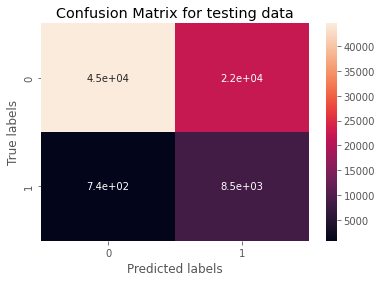

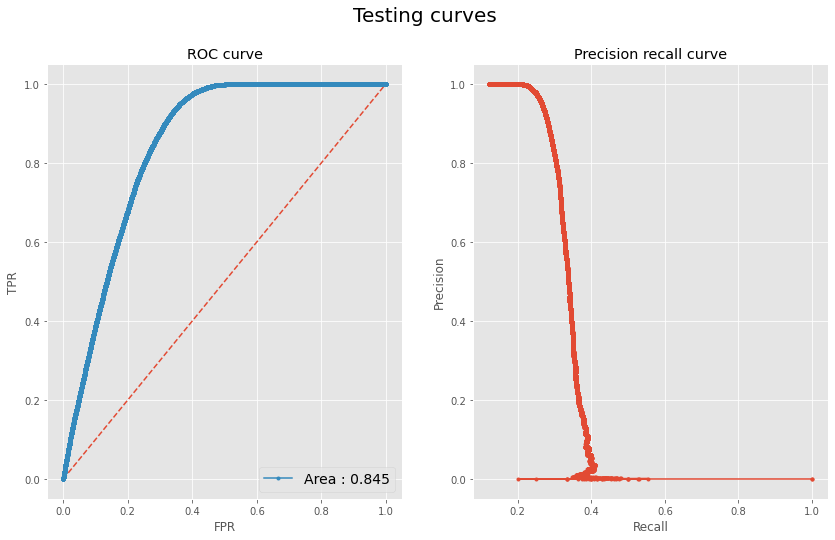

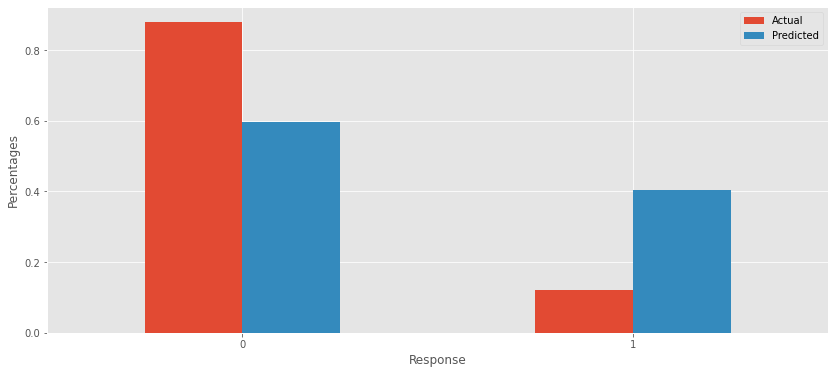

In [ ]:
# Checking all the scores for LGBM
get_metric(lgbm_clf,True)

## **Modelling With Catboost Classifier**

In [ ]:
# Fitting CatBoost with hypertuned parameters
cat_clf = CatBoostClassifier(learning_rate=0.03, l2_leaf_reg=1, iterations= 500, depth= 9, border_count= 20,eval_metric = 'AUC')

cat_clf.fit(X_train_pca, y_train,eval_set=(X_test_pca, y_test),early_stopping_rounds=150,verbose=50)

# Checking scores for catboost on train and test data
cat_pred_train = cat_clf.predict_proba(X_train_pca)[:,1]
cat_pred_test = cat_clf.predict_proba(X_test_pca)[:,1]

roc_train_cb = roc_auc_score(y_train, cat_pred_train)
roc_test_cb = roc_auc_score(y_test, cat_pred_test)

0:	test: 0.8318031	best: 0.8318031 (0)	total: 152ms	remaining: 1m 15s
50:	test: 0.8429034	best: 0.8429034 (50)	total: 5.06s	remaining: 44.5s
100:	test: 0.8439812	best: 0.8439812 (100)	total: 10.1s	remaining: 39.8s
150:	test: 0.8442880	best: 0.8442880 (150)	total: 15.1s	remaining: 34.9s
200:	test: 0.8444476	best: 0.8444652 (197)	total: 20.1s	remaining: 29.9s
250:	test: 0.8444497	best: 0.8445160 (225)	total: 25.1s	remaining: 24.9s
300:	test: 0.8443123	best: 0.8445160 (225)	total: 30s	remaining: 19.8s
350:	test: 0.8443064	best: 0.8445160 (225)	total: 34.9s	remaining: 14.8s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.844515993
bestIteration = 225

Shrink model to first 226 iterations.


In [ ]:
print(f"Catboost train roc: {round(roc_train_cb,2)}")
print(f"Catboost test roc: {round(roc_test_cb,2)}")

Catboost train roc: 0.85
Catboost test roc: 0.84


The classification report for training is 

              precision    recall  f1-score   support

           0       0.91      0.66      0.76    267427
           1       0.73      0.94      0.82    267427

    accuracy                           0.80    534854
   macro avg       0.82      0.80      0.79    534854
weighted avg       0.82      0.80      0.79    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.99      0.65      0.79     66972
           1       0.27      0.93      0.42      9250

    accuracy                           0.69     76222
   macro avg       0.63      0.79      0.60     76222
weighted avg       0.90      0.69      0.74     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.851,0.845
Accuracy,0.797,0.688
Recall,0.937,0.928
Precision,0.732,0.271
Log loss,7.017,10.783
F1 score,0.822,0.419


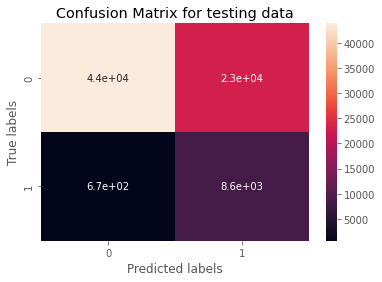

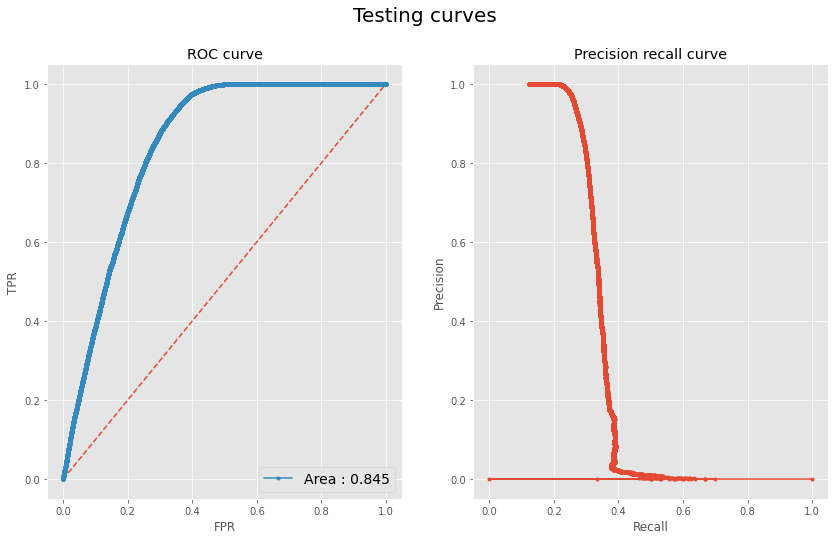

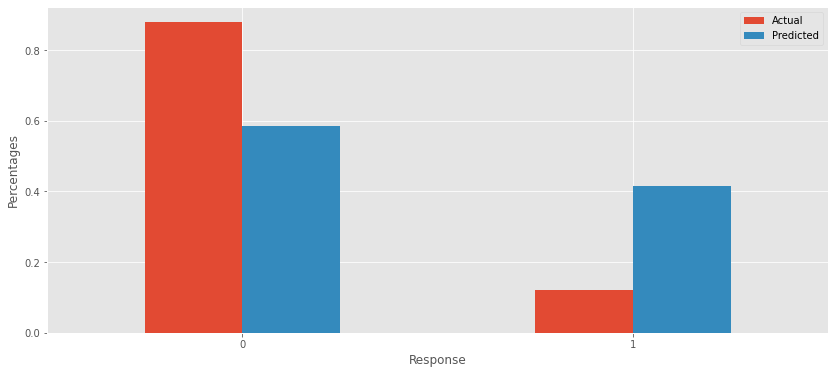

In [ ]:
# Getting all the scores for CatBoost
get_metric(cat_clf,True)

## **Modelling with a Stacked Classifier With LGBM and Catbbost models**

In [ ]:
# Fitting a stacked classifier.
# Using tuned catboost as meta classifier. Using LGBM, CatBoost as they were giving the best scores.
 
stacked_clf = StackingClassifier(classifiers =[lgbm_clf,cat_clf], meta_classifier = cat_clf, use_probas = True, use_features_in_secondary = True)

stacked_clf.fit(X_train_pca, y_train)   

stack_pred_train = stacked_clf.predict_proba(X_train_pca)[:,1]
stack_pred_test = stacked_clf.predict_proba(X_test_pca)[:,1]

roc_train_stacked = roc_auc_score(y_train,stack_pred_train)
roc_test_stacked = roc_auc_score(y_test,stack_pred_test)

In [ ]:
print(f"Stacked train roc: {round(roc_train_stacked,2)}")
print(f"Stacked test roc: {round(roc_test_stacked,2)}")

Stacked train roc: 0.88
Stacked test roc: 0.84


The classification report for training is 

              precision    recall  f1-score   support

           0       0.91      0.70      0.79    267427
           1       0.75      0.93      0.83    267427

    accuracy                           0.81    534854
   macro avg       0.83      0.81      0.81    534854
weighted avg       0.83      0.81      0.81    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     66972
           1       0.28      0.88      0.43      9250

    accuracy                           0.71     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.71      0.76     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.884,0.839
Accuracy,0.814,0.714
Recall,0.930,0.878
Precision,0.755,0.282
Log loss,6.423,9.861
F1 score,0.833,0.427


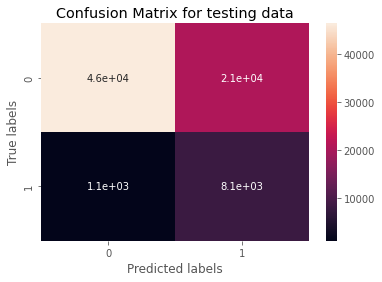

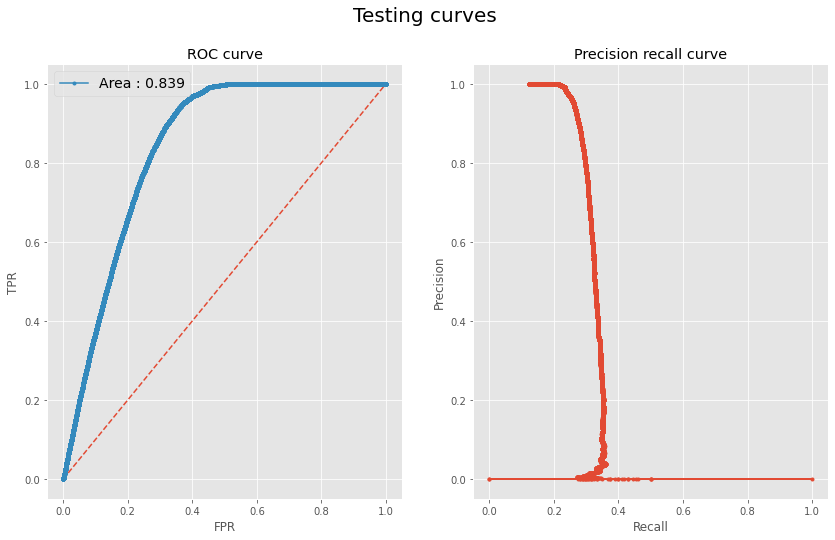

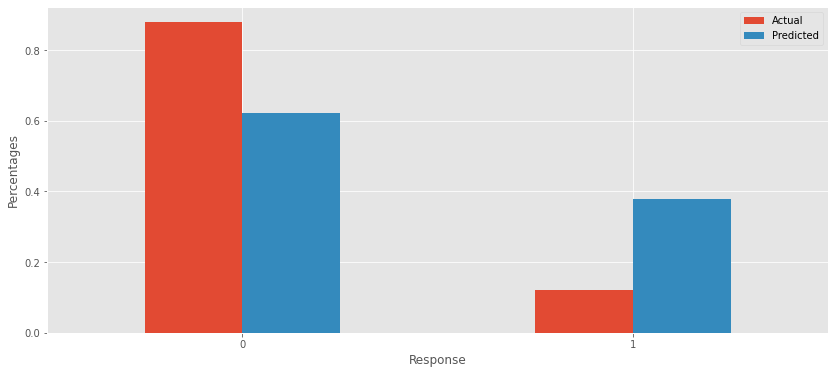

In [ ]:
# Getting all the scores for Stacked classifier
get_metric(stacked_clf,True)

## **Modelling With Voting Classifier**

In [ ]:
# Appeding both the models to estimators
# Using soft voting because we need probability of classes here
estimators = []

estimators.append(('LGBM', lgbm_clf))
estimators.append(('Catboost', cat_clf))
voting_clf = VotingClassifier(estimators, voting='soft')
voting_clf.fit(X_train_pca, y_train)

# Getting train and test roc auc scores
voting_pred_train = voting_clf.predict_proba(X_train_pca)[:,1]
voting_pred_test = voting_clf.predict_proba(X_test_pca)[:,1]

roc_train_voting = roc_auc_score(y_train,voting_pred_train)
roc_test_voting = roc_auc_score(y_test,voting_pred_test)

In [ ]:
print(f"Voting train roc: {round(roc_train_voting,2)}")
print(f"Voting test roc: {round(roc_test_voting,2)}")

Voting train roc: 0.86
Voting test roc: 0.85


The classification report for training is 

              precision    recall  f1-score   support

           0       0.92      0.67      0.77    267427
           1       0.74      0.94      0.83    267427

    accuracy                           0.81    534854
   macro avg       0.83      0.81      0.80    534854
weighted avg       0.83      0.81      0.80    534854
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66972
           1       0.28      0.92      0.42      9250

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.865,0.846
Accuracy,0.806,0.698
Recall,0.942,0.920
Precision,0.740,0.276
Log loss,6.715,10.438
F1 score,0.829,0.425


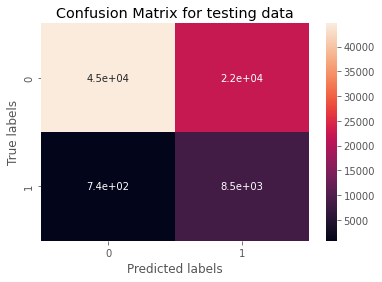

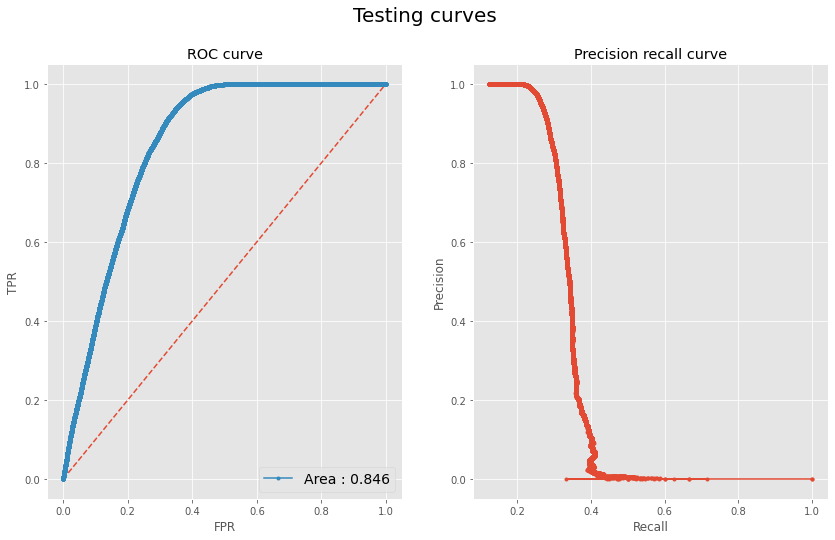

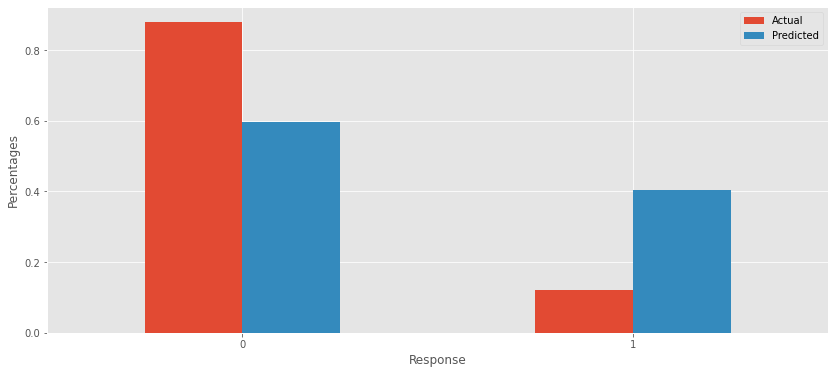

In [ ]:
# Getting all the scores on Voting model
get_metric(voting_clf,True)

In [ ]:
# Creating a dataframe of all the scores
results = pd.DataFrame(data = [('LGBM', roc_train_lgbm, roc_test_lgbm), ('CatBoost', roc_train_cb, roc_test_cb), ('Stacked Model',roc_train_stacked,roc_test_stacked ), ('Voting Model',roc_train_voting,roc_test_voting )], columns = ['Model', 'Train_ROC', 'Test_ROC']).set_index('Model')
results.round(3)

,Train_ROC,Test_ROC
Model,,
LGBM,0.869,0.845
CatBoost,0.851,0.845
Stacked Model,0.884,0.839
Voting Model,0.865,0.846


## **Modelling With Neural Network**

In [ ]:
# Creating train and validation test
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train_pca,y_train,test_size=0.2,random_state=0)

In [ ]:
Y_train_binary = y_train_nn.copy()
Y_val_binary = y_val.copy()
Y_test_binary = y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

In [ ]:
# Defining the network
# Using dropout layers to avoid overfitting by deactivating some of the neurons
# Using sigmoid in final layer as we are giving 1 output node

input_size = 6
output_size = 1
hidden_size = 20
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(output_size,'sigmoid')
                            ])
auc_met = tf.keras.metrics.AUC()
adm = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adm,loss='binary_crossentropy',metrics=[auc_met])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [ ]:
# Training for 50 epochs
model.fit(X_train_nn, Y_train_binary, validation_data=(X_val,Y_val_binary),epochs=50, batch_size=50,verbose = 2,callbacks = [early_stopping])

Epoch 1/50
8558/8558 - 11s - loss: 0.4525 - auc: 0.8245 - val_loss: 0.4335 - val_auc: 0.8428 - 11s/epoch - 1ms/step
Epoch 2/50
8558/8558 - 10s - loss: 0.4402 - auc: 0.8359 - val_loss: 0.4315 - val_auc: 0.8444 - 10s/epoch - 1ms/step
Epoch 3/50
8558/8558 - 11s - loss: 0.4391 - auc: 0.8366 - val_loss: 0.4314 - val_auc: 0.8450 - 11s/epoch - 1ms/step
Epoch 4/50
8558/8558 - 11s - loss: 0.4388 - auc: 0.8370 - val_loss: 0.4315 - val_auc: 0.8433 - 11s/epoch - 1ms/step
Epoch 5/50
8558/8558 - 11s - loss: 0.4381 - auc: 0.8373 - val_loss: 0.4313 - val_auc: 0.8451 - 11s/epoch - 1ms/step
Epoch 6/50
8558/8558 - 11s - loss: 0.4383 - auc: 0.8380 - val_loss: 0.4314 - val_auc: 0.8450 - 11s/epoch - 1ms/step
Epoch 7/50
8558/8558 - 11s - loss: 0.4382 - auc: 0.8377 - val_loss: 0.4311 - val_auc: 0.8453 - 11s/epoch - 1ms/step
Epoch 8/50
8558/8558 - 11s - loss: 0.4377 - auc: 0.8378 - val_loss: 0.4311 - val_auc: 0.8444 - 11s/epoch - 1ms/step
Epoch 9/50
8558/8558 - 10s - loss: 0.4376 - auc: 0.8382 - val_loss: 0.43

In [ ]:
# Predicting using nn
nn_pred = np.round(model.predict_on_batch(X_test_pca)).astype(int)

In [ ]:
print(f"The auc score {round(roc_auc_score(y_test,nn_pred),2)}")

The auc score 0.79


In [ ]:
# Getting all the scores for Neural Network
print(classification_report(y_test,nn_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78     66972
           1       0.27      0.94      0.42      9250

    accuracy                           0.68     76222
   macro avg       0.63      0.79      0.60     76222
weighted avg       0.90      0.68      0.74     76222



## **Some More Utility Functions**

In [ ]:
# This function would give importance using lime
def interpret_with_lime(model, X_test):
  # New data
  interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='classification')
  

  exp = interpretor.explain_instance(
      data_row=X_test.iloc[10], 
      predict_fn=model.predict_proba
  )

  exp.show_in_notebook(show_table=True)

## **Interpreting The Model Using Lime:**

In [ ]:
# calling the UDF for lime with optimal logistic regression model
interpret_with_lime(optimal_lr_clf,X_test)

## **Interpreting The Model Using Shap**

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

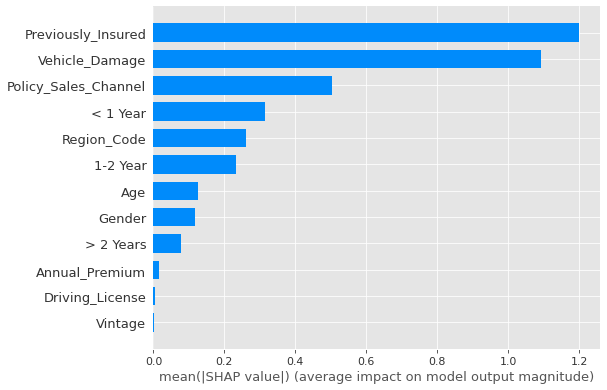

In [ ]:
# Initializaing Shap
shap.initjs()

X_shap=X_train.copy()

# Creating a linear explainer here
explainer = shap.Explainer(optimal_lr_clf, masker=shap.maskers.Impute(data=X_train),
                           feature_names=X_train.columns, algorithm="linear")

# Plotting barplot for all the features
lr_shap_values = explainer.shap_values(X_shap)
shap.summary_plot(lr_shap_values, X_shap, plot_type="bar")


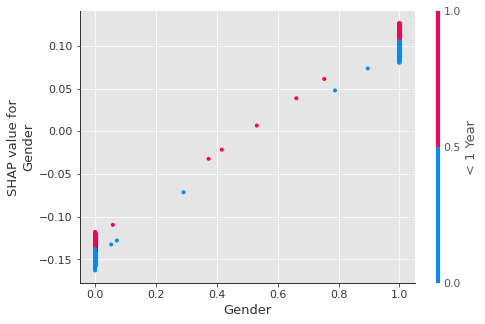

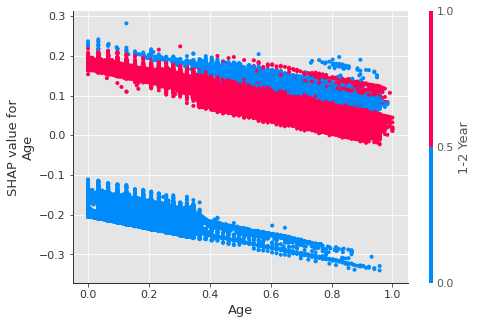

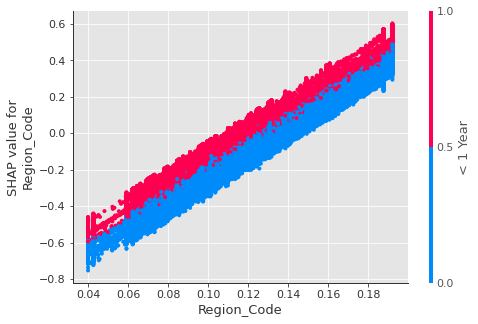

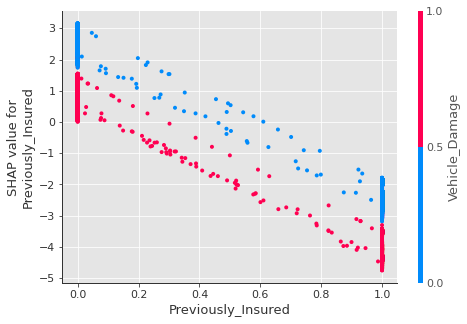

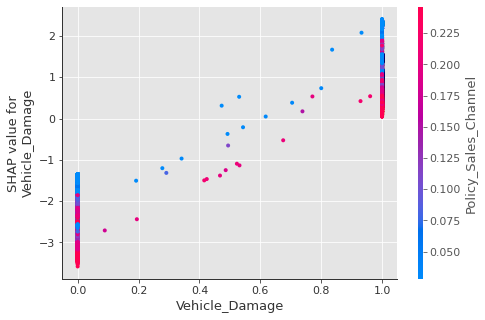

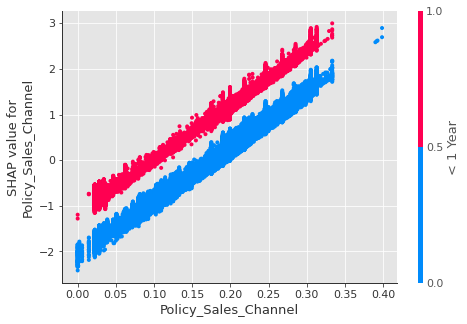

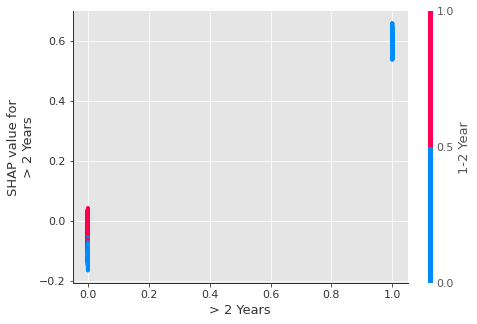

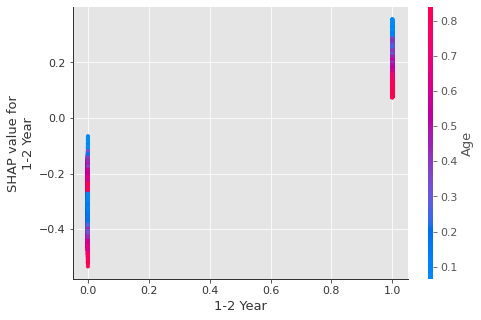

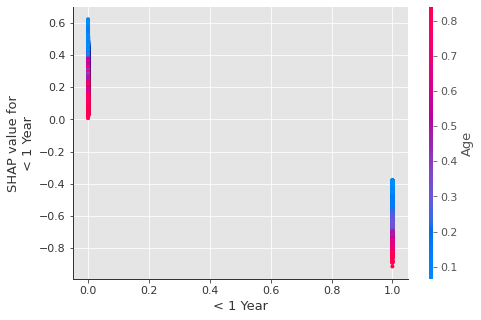

In [ ]:
# Plotting dependence plots for all the features with high importance

top_vars = ['Gender', 'Age',  'Region_Code', 'Previously_Insured',
       'Vehicle_Damage', 'Policy_Sales_Channel',
       '> 2 Years', '1-2 Year', '< 1 Year']
for i in top_vars:
  shap.dependence_plot(i, lr_shap_values, X_train)


## **Interpreting The Model Using Eli5**

In [ ]:
# Craeting a permutationImportance object to find feature importance
permutation_imp = PermutationImportance(optimal_lr_clf, random_state=1)
permutation_imp.fit(X_train, y_train)
eli5.show_weights(permutation_imp, feature_names = X_train.columns.tolist())

Weight,Feature
0.0943 ± 0.0013,Vehicle_Damage
0.0847 ± 0.0008,Previously_Insured
0.0541 ± 0.0010,< 1 Year
0.0509 ± 0.0004,Policy_Sales_Channel
0.0045 ± 0.0002,Region_Code
0.0041 ± 0.0005,1-2 Year
0.0017 ± 0.0001,Gender
0.0007 ± 0.0001,Driving_License
0.0006 ± 0.0001,> 2 Years
0.0000 ± 0.0000,Vintage


> **Both Eli5 and Shap are giving similar importance for the features.**

## **Conclusion:**

> **We were able to deal with class imbalance.**

> **Most of the models gave pretty good scores. However, overfitting was seen in most of them**

> **Overfitting was dealt with PCA.**

> **CatBoost gave the best roc scores, train:	0.851	and test: 0.845  .**